In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
df = pd.read_csv('/content/drive/MyDrive/ML_HW2_Q1/train.csv')
print(df['Model'].nunique())
print(df['State'].nunique())
print(df['City'].nunique())
print(df['Make'].nunique())
print(df['Year'].nunique())

2094
59
2524
56
22


In [5]:
class Linear_Regression:
  def __init__(self, x, target, columns, learning_rate, epoch, non_numeric_columns, convert_to_vector):
    self.columns = columns
    self.x = x
    self.target = target
    self.learning_rate = learning_rate
    self.epoch = epoch
    self.non_numeric_columns = non_numeric_columns
    self.non_numeric_dic = {}
    self.convert_to_vector = convert_to_vector
    self.convert_to_vector_value = {}
    self.final_columns = self.columns.copy()

  def one_hot_encode(self, dictionary, values):
    for x in values:
        if x not in dictionary.keys():
            dictionary[x] = len(dictionary)

  def one_hot_decode(self, dictionary, key):
    if key in dictionary.keys():
        return dictionary[key]
    dictionary[key] = len(dictionary)
    return dictionary[key]

  def convert_to_numeric(self):
    for i in self.non_numeric_columns:
      dictionary = {}
      self.non_numeric_dic[i] = dictionary
      self.one_hot_encode(dictionary, self.x[i].values)
      self.x[i] = [self.one_hot_decode(dictionary, j) for j in self.x[i].values]

  def normalize(self):
    self.normalize_dictionary = {}
    for i in self.final_columns:
      if i in self.convert_to_vector:
        continue
      mean = np.mean(self.x[i])
      var = np.var(self.x[i])
      self.x[i] = (self.x[i] - mean) / var
      self.normalize_dictionary[i] = {'mean':mean, 'var':var}
  
  def gradian_function(self, predict, w, x_vector):
    return np.dot(predict - self.target, x_vector) / len(x_vector)

  def cost_function_simplified(self, predicts):
    return np.sum((predicts - self.target) ** 2) / (2 * len(self.target))

  def convert_columns_to_Vector(self):
    for i in self.convert_to_vector:
      if i in self.final_columns:
        self.convert_to_vector_value[i] = len(self.non_numeric_dic[i])
        self.final_columns.remove(i)
      count = self.convert_to_vector_value[i]
      for j in range(count):
        self.final_columns.append(i + str(j))
        self.x[i + str(j)] = np.where(self.x[i] == j, 1, 0)

  def LR_GD(self):
    self.convert_to_numeric()
    self.normalize()
    self.convert_columns_to_Vector()
    x_vector = self.x.loc[:, self.final_columns].to_numpy()
    # Adding A New Column With Value 1, Just To Set The Bias Along Side With W
    bias = np.ones(len(self.x))
    x_vector = np.c_[x_vector, bias]
    w = [random.random() for x in range(len(self.final_columns) + 1)]
    # w = [random.random() for x in range(len(columns))]
    # w.append(np.mean(self.target))
    predict = np.dot(x_vector, w)
    costs = []
    cost = self.cost_function_simplified(predict)
    costs.append(cost)
    for i in range(self.epoch):
      gradian = self.gradian_function(predict, w, x_vector)
      w = w - (self.learning_rate * gradian)
      predict = np.dot(x_vector, w)
      predict = np.array(predict)
      cost = self.cost_function_simplified(predict)
      costs.append(cost)
    plt.plot([i for i in range(len(costs))], costs)
    plt.xlabel('Test Number')
    plt.ylabel('Cost Function')
    plt.title('Cost-Function-Result')
    plt.savefig("Cost-Function-Image.png")
    plt.show()
    return w

  def test(self, x_vector, target, w, show_plot = True, path = ''):
    for col in self.non_numeric_columns:
      dic = self.non_numeric_dic[col]
      x_vector[col] = [self.one_hot_decode(dic, i) for i in x_vector[col].values]

    for col in self.columns:
      if col in self.convert_to_vector:
        continue
      dic = self.normalize_dictionary[col]
      x_vector[col] = [(i - dic['mean']) / dic['var'] for i in x_vector[col]]

    for i in self.convert_to_vector:
      count = self.convert_to_vector_value[i]
      for j in range(count):
        x_vector[i + str(j)] = np.where(x_vector[i] == j, 1, 0)

    x_matrix = x_vector.loc[:, self.final_columns].to_numpy()
    bias_matrix = np.ones(len(x_vector))
    x_matrix = np.c_[x_matrix, bias_matrix]
    predict = np.absolute(np.dot(x_matrix, w))
    if not show_plot:
      df = pd.read_csv('/content/drive/MyDrive/ML_HW2_Q1/test.csv')
      df['Price'] = predict
      df.loc[:,['Price', 'CarId']].to_csv('/content/predict.csv', index = False)
      return
    plt.plot([x for x in range(len(target))], np.array(target), color='b')
    plt.plot([x for x in range(len(predict))], np.array(predict), color='r')
    plt.savefig('Test.png')
    plt.show()
    mins = [min(target), min(predict)]
    maxs = [max(target), max(predict)]
    plt.plot([min(mins), max(maxs)], [min(mins), max(maxs)])
    plt.scatter(predict, target)
    plt.xlabel('Predicted Price')
    plt.ylabel('Price')
    plt.savefig('Professional-Result.png')
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


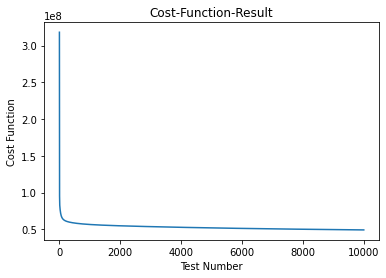

W:  [ 2.01979966e+04 -7.28124161e+01  6.19186424e+03 -8.88408583e+03
 -8.80781761e+03 -1.51417721e+04 -1.08623618e+04 -9.06467950e+03
 -1.71305811e+04  1.65678168e+03 -1.47721884e+04 -2.58579052e+03
 -1.27679481e+04 -1.20241267e+04 -2.44621360e+03 -2.15924191e+03
 -3.02089313e+03 -7.07884197e+03 -1.49936924e+04 -1.62016687e+04
 -6.06330561e+03 -8.82450816e+03 -1.18589905e+04 -2.29327055e+03
 -1.76159441e+04 -4.57769896e+03 -1.14439632e+04  2.93393743e+04
 -2.19370705e+03  1.29214983e+04 -1.91681733e+04 -1.28621618e+04
  2.07691586e+04 -1.68037843e+04 -6.49496317e+03  2.25425260e+03
 -9.93962319e+03 -1.68060971e+04 -9.66791441e+03 -1.80256364e+04
  6.38345297e+03  8.49074964e+04  2.57974267e+04  4.18343634e+04
  1.62766249e+03  1.14619141e+01 -4.39769791e+03 -8.02367327e+03
  1.29812342e+04 -1.10101989e+03  2.00659312e+03  3.70388347e+04
  2.23918491e+04  6.74466506e+04  2.69939281e+03 -5.68307464e+02
  1.38299140e+03  1.51708929e+02  3.64628953e+03  1.06743233e+03
 -2.47263767e+02  6.3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:102: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


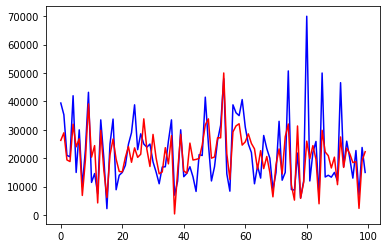

/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


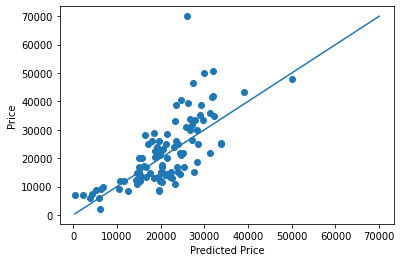

In [13]:
############################################# My Test #############################################
df = pd.read_csv('/content/drive/MyDrive/ML_HW2_Q1/train.csv')
test = df.iloc[99900:, :]
df = df.iloc[:99900, :]
# columns = ['Year', 'Mileage', 'City', 'State', 'Make', 'Model']
# non_numeric_columns = ['City', 'State', 'Make', 'Model']
columns = ['Year', 'Mileage', 'State', 'Make', 'Model']
non_numeric_columns = ['State', 'Make', 'Model']
vectorize = ['Make', 'State']
target = df['Price']
lr = Linear_Regression(df.loc[:,columns], target, columns, 0.25, 10000, non_numeric_columns, vectorize)
w = lr.LR_GD()
print('W: ', w)
lr.test(test.loc[:,columns], test.loc[:,['Price']].values, w)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


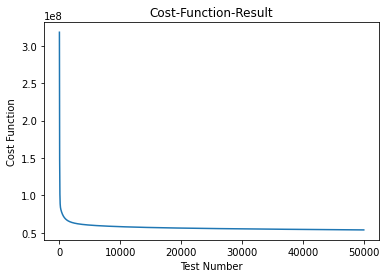

W:  [ 2.01021624e+04 -2.33738928e+01  2.09281846e+03  1.02988200e+03
 -2.14192663e+02  1.27764364e+02  2.25024165e+03 -1.17842839e+03
  1.11301331e+03  1.43563094e+03  4.10150421e+02  6.59080715e+01
 -5.40873306e+02  1.25356610e+02  7.65352586e+02 -6.26476361e+02
  7.53157105e+02  1.75798109e+03 -1.06564684e+03 -1.94841011e+02
 -7.21213732e+02 -5.22315550e+01 -7.72002821e+02  4.57244435e+02
 -4.62665794e+02 -1.04669086e+03  6.20599829e+02 -3.66145565e+02
 -6.01674949e+02 -8.78662219e+02  5.29076110e+02  1.14787061e+03
 -3.35045913e+02 -1.70239666e+02  4.90512237e+02  4.56027851e+02
  6.51183349e+02 -5.07381458e+02  6.86469630e+02  2.49014338e+03
  2.60601853e+03  1.00059032e+03  1.29913965e+03  1.69999036e+03
  1.88269146e+02  2.13472952e+03  2.27958085e+03  1.23030232e+03
  2.87312385e+02  1.20565389e+03  1.48231733e+02  6.71225515e+01
 -3.75996243e+02  1.72994359e+03  2.53359822e+03  9.46426199e+01
  5.11810960e+01 -1.24743097e+02  1.24138164e+02  9.15528158e+01
  4.20442246e+01 -5.4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:102: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [14]:
############################################# Upload #############################################
df = pd.read_csv('/content/drive/MyDrive/ML_HW2_Q1/train.csv')
target = df['Price']
test_path = '/content/drive/MyDrive/ML_HW2_Q1/test.csv'
test = pd.read_csv(test_path)
# columns = ['Year', 'Mileage', 'City', 'State', 'Make', 'Model']
# non_numeric_columns = ['City', 'State', 'Make', 'Model']
columns = ['Year', 'Mileage', 'State', 'Make', 'Model']
non_numeric_columns = ['State', 'Make', 'Model']
convert_to_vector = ['State', 'Make']
# convert_to_vector = ['City', 'State', 'Make', 'Model']
show_plot = False
lr = Linear_Regression(df.loc[:,columns], target, columns, 0.015, 50000, non_numeric_columns, convert_to_vector)
w = lr.LR_GD()
print('W: ', w)
lr.test(test.loc[:,columns], [], w, show_plot, test_path)

In [60]:
# ////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# def one_hot_encode(dictionary, df):
#     for x in df:
#         if x not in dictionary.keys():
#             dictionary[x] = len(dictionary)

# def one_hot_decode(dictionary, key):
#     if key in dictionary.keys():
#         return dictionary[key]
#     dictionary[key] = len(dictionary)
#     return dictionary[key]


# # def loss_function(predicted, target):
# #     return ((predicted - target) ** 2) / 2
# #
# # def cost_function(predicts, targets):
# #     return sum([loss_function(predicts[x], targets[x]) for x in range(len(targets))]) / len(targets)

# def cost_function_simplified(predicts, targets):
#     return np.sum((predicts - targets) ** 2) / (2 * len(targets))

# def gradian_function(predict, target, w, x_vector):
#     return np.dot(predict - target, x_vector) / len(x_vector)
#     # diff = predict - target
#     # gradian = np.dot(diff, x_vector)
#     # return gradian / len(x_vector)

# # df = pd.read_csv('/content/drive/MyDrive/ML_HW2_Q1/train.csv')
# df = pd.read_csv('/content/drive/MyDrive/ML_HW2_Q1/train.csv').iloc[:99900, :]

# # Converting Non Numeric Values To Numeric Values By Using one_hot_function
# city_rank = {}
# one_hot_encode(city_rank, df['City'])
# rank = [city_rank[x] for x in df['City']]
# city_mean = np.mean(rank)
# city_var = np.var(rank)
# df['City Rank'] = [(x - city_mean) / city_var for x in rank]

# state_rank = {}
# one_hot_encode(state_rank, df['State'])
# rank = [state_rank[x] for x in df['State']]
# state_mean = np.mean(rank)
# state_var = np.var(rank)
# df['State Rank'] = [(x - state_mean) / state_var for x in rank]

# # vin_rank = {}
# # one_hot_encode(vin_rank, df['Vin'])
# # rank = [vin_rank[x] for x in df['Vin']]
# # vin_mean = np.mean(rank)
# # vin_var = np.var(rank)
# # df['Vin Rank'] = [(x - vin_mean) / vin_var for x in rank]

# make_rank = {}
# one_hot_encode(make_rank, df['Make'])
# rank = [make_rank[x] for x in df['Make']]
# make_mean = np.mean(rank)
# make_var = np.var(rank)
# df['Make Rank'] = [(x - make_mean) / make_var for x in rank]

# model_rank = {}
# one_hot_encode(model_rank, df['Model'])
# rank = [model_rank[x] for x in df['Model']]
# model_mean = np.mean(rank)
# model_var = np.var(rank)
# df['Model Rank'] = [(x - model_mean) / model_var for x in rank]

# year_mean = np.mean(df['Year'])
# year_var = np.var(df['Year'])
# df['Year'] = [(x - year_mean) / year_var for x in df['Year']]

# mileage_mean = np.mean(df['Mileage'])
# mileage_var = np.var(df['Mileage'])
# df['Mileage'] = [(x - mileage_mean) / mileage_var for x in df['Mileage']]


# # columns = ['Year', 'Mileage', 'City Rank', 'State Rank', 'Vin Rank', 'Make Rank', 'Model Rank']
# columns = ['Year', 'Mileage', 'City Rank', 'State Rank', 'Make Rank', 'Model Rank']
# x_vector = df.loc[:, columns].to_numpy()

# # Adding A New Column With Value 1, Just To Set The Bias Along Side With W
# bias = np.ones(len(df))
# x_vector = np.c_[x_vector, bias]
# # print('x_vector:')
# # print(x_vector[0])

# target = np.array(df.iloc[:,0].values)
# # target_mean = np.mean(target)
# # target_var = np.var(target)
# # target = (target - target_mean) / target_var
# # print('target:')
# # print(target)

# learning_rate = 0.0015
# epoch = 30000

# # Setting The Bias Number In This Vector Along Side Of Xi
# # w = [((random.random() * 1)) for x in range(len(columns) + 1)]
# w = [((random.random() * 1) + 0) for x in range(len(columns) + 1)]
# # w = [((random.random() * 1) + 0) for x in range(len(columns))]
# # w.append(np.mean(df['Price']))
# # w.append(np.mean(df['Price']))
# # w.append(1)
# # w.append(df['Price'].mean())
# # w = [1 for x in range(len(columns) + 1)]
# # print('W:')
# # print(w)


# predict = np.dot(x_vector, w)
# # print('predict:')
# # print(predict)
# cost = cost_function_simplified(predict, target)
# # print('cost:')
# # print(cost)

# coasts = []
# for i in range(epoch):
#     gradian = gradian_function(predict, target, w, x_vector)
#     w = w - (learning_rate * gradian)
#     # print('New W:')
#     # print(w)
#     predict = np.dot(x_vector, w)
#     # print('Predict:')
#     # print(predict)
#     cost = cost_function_simplified(predict, target)
#     # print('cost:')
#     # print(cost)
#     coasts.append(cost)

# x = [i for i in range(len(coasts))]
# # plt.plot(x, coasts, marker = 'o', mec = 'r', mfc = 'r', linestyle  = "--")
# plt.plot(x, coasts)
# plt.xlabel('Test Number')
# plt.ylabel('Cost Function')
# plt.title('Cost Function Result')
# plt.savefig("Loss-Function-Plot.png")
# plt.show()


# ###################################################################
# ##############         My Test          ####################
# df = pd.read_csv('/content/drive/MyDrive/ML_HW2_Q1/train.csv').iloc[99900:, :]

# # Converting Non Numeric Values To Numeric Values By Using rank function
# df['City Rank'] = [(one_hot_decode(city_rank, x) - city_mean) / city_var for x in df['City']]
# # df['City Rank'] = [one_hot_decode(city_rank, x) for x in df['City']]
# # df['City Rank'] = [(x - np.mean(df['City Rank'])) / np.var(df['City Rank']) for x in df['City Rank']]
# df['State Rank'] = [(one_hot_decode(state_rank, x) - state_mean) / state_var for x in df['State']]
# # df['State Rank'] = [one_hot_decode(state_rank, x) for x in df['State']]
# # df['State Rank'] = [(x - np.mean(df['State Rank'])) / np.var(df['State Rank']) for x in df['State Rank']]
# # df['Vin Rank'] = [(one_hot_decode(vin_rank, x) - vin_mean) / vin_var for x in df['Vin']]
# df['Make Rank'] = [(one_hot_decode(make_rank, x) - make_mean) / make_var for x in df['Make']]
# # df['Make Rank'] = [one_hot_decode(make_rank, x) for x in df['Make']]
# # df['Make Rank'] = [(x - np.mean(df['Make Rank'])) / np.var(df['Make Rank']) for x in df['Make Rank']]
# df['Model Rank'] = [(one_hot_decode(model_rank, x) - model_mean) / model_var for x in df['Model']]
# # df['Model Rank'] = [one_hot_decode(model_rank, x) for x in df['Model']]
# # df['Model Rank'] = [(x - np.mean(df['Model Rank'])) / np.var(df['Model Rank']) for x in df['Model Rank']]

# df['Year'] = [(x - year_mean) / year_var for x in df['Year']]

# df['Mileage'] = [(x - mileage_mean) / mileage_var for x in df['Mileage']]

# test_x = df.loc[:, columns].to_numpy()
# test_bias = np.ones(len(df))
# test_x = np.c_[test_x, test_bias]

# df['Predicted Price'] = np.dot(test_x, w)
# # df['Predicted Price'] = [abs(x) for x in df['Predicted Price']]
# # df['Predicted Price'] = [(x * target_var) + target_mean for x in df['Predicted Price']]

# print('Total Predicted Price:')
# print(df['Predicted Price'].to_string())
# print('w:')
# print(w)
# print('x_vector:')
# print(test_x)

# plt.subplot(211)
# plt.plot(df['Price'])
# plt.subplot(212)
# plt.plot(df['Predicted Price'])
# plt.show()

# plt.plot([x for x in range(len(df))], np.array(df.iloc[:,0].values), color='b')
# plt.plot([x for x in range(len(df))], np.array(df.loc[:,['Predicted Price']].values), color='r')
# plt.savefig('My Test On 10 Test date.png')
# plt.show()
# # print('Target Mean:')
# # print(target_mean)
# # print('Target Var:')
# # print(target_var)
# mins = [min(df['Predicted Price']), min(df['Price'])]
# maxs = [max(df['Predicted Price']), max(df['Price'])]
# plt.plot([min(mins), max(maxs)], [min(mins), max(maxs)])
# plt.scatter(df['Predicted Price'], df['Price'])
# plt.xlabel('Predicted Price')
# plt.ylabel('Price')
# plt.savefig('Professional-Result.png')
# plt.show()
# print('Cost:')
# print(cost_function_simplified(df['Predicted Price'], df['Price']))
# exit(0)
# ###################################################################
# # df = pd.read_csv('/content/drive/MyDrive/ML_HW2_Q1/test.csv')
# # # just in case that we can see the result, if we get all test.csv file, we get error of merror space due to its huge size
# # # df = pd.read_csv('/content/train.csv')

# # # Converting Non Numeric Values To Numeric Values By Using rank function
# # df['City Rank'] = [(one_hot_decode(city_rank, x) - city_mean) / city_var for x in df['City']]
# # df['State Rank'] = [(one_hot_decode(state_rank, x) - state_mean) / state_var for x in df['State']]
# # # df['Vin Rank'] = [(one_hot_decode(vin_rank, x) - vin_mean) / vin_var for x in df['Vin']]
# # df['Make Rank'] = [(one_hot_decode(make_rank, x) - make_mean) / make_var for x in df['Make']]
# # df['Model Rank'] = [(one_hot_decode(model_rank, x) - model_mean) / model_var for x in df['Model']]


# # # df['City Rank'] = [one_hot_decode(city_rank, x) for x in df['City']]
# # # df['State Rank'] = [one_hot_decode(state_rank, x) for x in df['State']]
# # # # df['Vin Rank'] = [(one_hot_decode(vin_rank, x) - vin_mean) / vin_var for x in df['Vin']]
# # # df['Make Rank'] = [one_hot_decode(make_rank, x) for x in df['Make']]
# # # df['Model Rank'] = [one_hot_decode(model_rank, x) for x in df['Model']]

# # # mean = np.mean(df['City Rank'])
# # # var = np.var(df['City Rank'])
# # # df['City Rank'] = [(x - mean) / var for x in df['City Rank']]
# # # mean = np.mean(df['State Rank'])
# # # var = np.var(df['State Rank'])
# # # df['State Rank'] = [(x - mean) / var for x in df['State Rank']]
# # # mean = np.mean(df['Make Rank'])
# # # var = np.var(df['Make Rank'])
# # # df['Make Rank'] = [(x - mean) / var for x in df['Make Rank']]
# # # mean = np.mean(df['Model Rank'])
# # # var = np.var(df['Model Rank'])
# # # df['Model Rank'] = [(x - mean) / var for x in df['Model Rank']]
# # # df['Vin Rank'] = [(one_hot_decode(vin_rank, x) - vin_mean) / vin_var for x in df['Vin']]


# # df['Year'] = [(x - year_mean) / year_var for x in df['Year']]

# # df['Mileage'] = [(x - mileage_mean) / mileage_var for x in df['Mileage']]

# # # print(df.head().to_string())

# # # columns = ['Year', 'Mileage', 'City Rank', 'State Rank', 'Vin Rank', 'Make Rank', 'Model Rank']
# # test_x = df.loc[:, columns].to_numpy()
# # test_bias = np.ones(len(df))
# # test_x = np.c_[test_x, test_bias]

# # df['Price'] = np.dot(test_x, w)
# # # print(df.to_string())
# # # res_df = pd.read_csv('/content/drive/MyDrive/ML_HW2_Q1/test.csv')
# # # res_df['Price'] = df['Price']
# # # print(res_df.to_string())
# # df.loc[:,['Price', 'CarId']].to_csv('/content/predict.csv', index = False)



# ########################### SK_Learn #####################
# # df = pd.read_csv('/content/train.csv')
# # non_numeric = ['Model', 'Make', 'Vin', 'State', 'City']
# # df['Model'] = [one_hot_decode(model_rank, x) for x in df['Model']]
# # df['Make'] = [one_hot_decode(make_rank, x) for x in df['Make']]
# # df['Vin'] = [one_hot_decode(vin_rank, x) for x in df['Vin']]
# # df['State'] = [one_hot_decode(state_rank, x) for x in df['State']]
# # df['City'] = [one_hot_decode(city_rank, x) for x in df['City']]
# # from sklearn.linear_model import LinearRegression
# # lr_model = LinearRegression()
# # lr_model.fit(df.iloc[:,1:], df.iloc[:,0])
# # w = lr_model.coef_
# # b = lr_model.intercept_
# # df['Predicted-Price'] = np.dot(df.iloc[:,1:], w) + b
# # mins = [min(df['Price']), min(df['Predicted-Price'])]
# # maxs = [max(df['Price']), max(df['Predicted-Price'])]
# # plt.plot([min(mins), max(maxs)], [min(mins), max(maxs)])
# # plt.scatter(df['Price'], df['Predicted-Price'])
# # plt.title('AAAAAAAAAAAAAAAAAAAAAAAA')
# # plt.xlabel('Price')
# # plt.ylabel('sk_learn Price')
# # plt.savefig('sk_learn-MyPredict.png')
# # plt.show()
# # test_df = pd.read_csv('/content/test.csv')
# # test_df['Model'] = [one_hot_decode(model_rank, x) for x in test_df['Model']]
# # test_df['Make'] = [one_hot_decode(make_rank, x) for x in test_df['Make']]
# # test_df['Vin'] = [one_hot_decode(vin_rank, x) for x in test_df['Vin']]
# # test_df['State'] = [one_hot_decode(state_rank, x) for x in test_df['State']]
# # test_df['City'] = [one_hot_decode(city_rank, x) for x in test_df['City']]

# # test_df['Price'] = np.dot(test_df.iloc[:,1:], w) + b
# # mins = [min(res_df['Price']), min(test_df['Price'])]
# # maxs = [max(res_df['Price']), max(test_df['Price'])]
# # plt.plot([min(mins), max(maxs)], [min(mins), max(maxs)])
# # plt.scatter(res_df['Price'], test_df['Price'])
# # plt.xlabel('My Price')
# # plt.ylabel('sk_learn Price')
# # plt.savefig('sk_learn-MyPredict.png')
# # plt.show()

TypeError: ignored